# Setting IMAGINE to do the fitting

I will use this notebook for testing each of the components needed to set up IMAGINE to fit the model to the SNR data.

In [1]:
import os, sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import imagine as img
# IMAGINE extension package
import imagine_snrs as img_snrs
import shell

## Datasets/Measurements

The first step is including the observational data in IMAGINE. I've added a `datasets` module to the directory `imagine_snrs`, which contains three IMAGINE [dataset](https://imagine-code.readthedocs.io/en/latest/components.html#datasets) classes (for Stokes I, U and Q). These new classes load the fits files, extracting coordinate information and adjust to the internal format. 

This assumes that the following files are available in the present repository:

* data/I_DA530.fits
* data/Q_DA530.fits
* data/U_DA530.fits


Here is an example of how to access one of these dataset objects:

In [2]:
dset = img_snrs.datasets.SNR_DA530_I()
dset.object_id

'SNR G093.3+06.9'

In practice, we would like to load them onto [Measurements](https://imagine-code.readthedocs.io/en/latest/components.html#observables-and-observable-dictionaries) objects (which hold a set of observational datasets).
This is done in the cell below. For convenience, the `Measurements` contain a `show` method, which allows quick inspection:

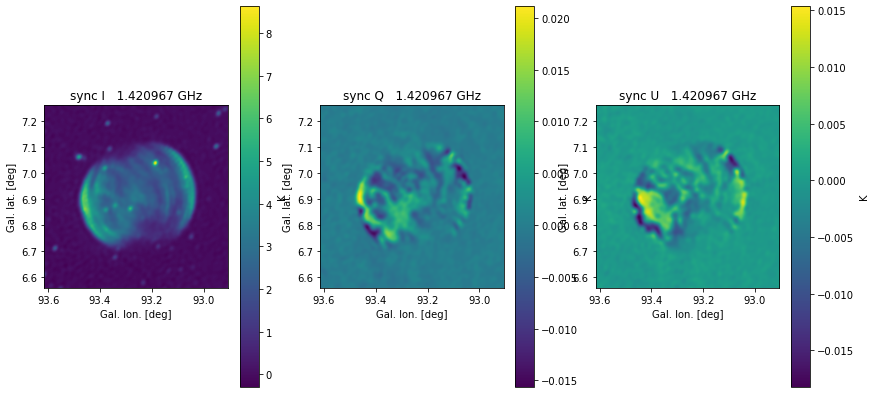

In [3]:
measurements = img.observables.Measurements(img_snrs.datasets.SNR_DA530_I(),
                                            img_snrs.datasets.SNR_DA530_Q(),
                                            img_snrs.datasets.SNR_DA530_U())
plt.figure(figsize=(14,7))
measurements.show()

## Fields

The next step is expressing our models for each of the shell components (magnetic field, thermal electron density, and cosmic ray electron density) as IMAGINE [Fields](https://imagine-code.readthedocs.io/en/latest/components.html#fields) (tutorial [here](https://imagine-code.readthedocs.io/en/latest/tutorial_fields.html)).

For definiteness, let us start by defining a grid:

In [4]:
L = 70*u.pc; N = 150
grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                              box=[[-L,L],[-L,L],[-L,L]], 
                              # Grid resolution
                              resolution=[N, N, N])

### Electron distribution 

Each of the physical components (magnetic field, thermal electron density, cosmic ray electron density) needs to be represented by a different IMAGINE Field object. I have implemented these in the `imagine_snrs.fields` module. The properties of the shell are set up inside the `SupernovaShellThermalElectrons`, and the other components will use the same setup (and depend on `SupernovaShellThermalElectrons` to re-use the same `FieldTransformer` object).

Below, I exemplify/test the `SupernovaShellThermalElectrons` class.

../shell/visualization.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_slice.value, **kwargs)


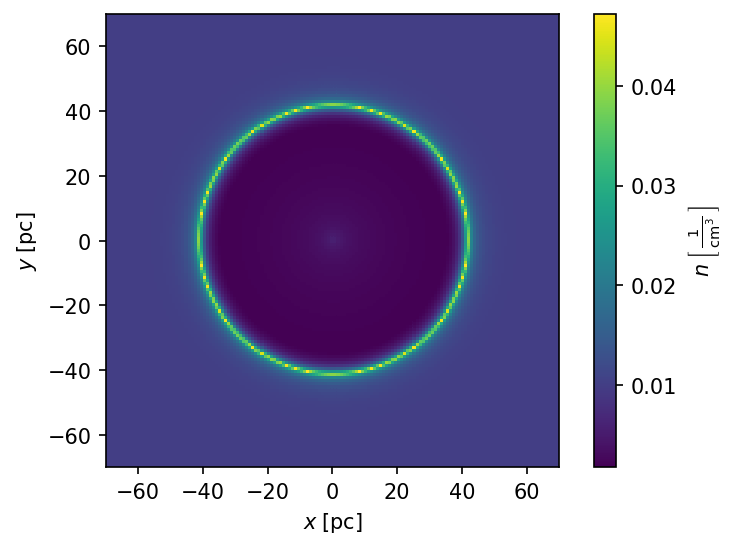

In [5]:
# Parameters dictionary, including shell parameters
parameters = {'initial_electron_density': 0.01*u.cm**-3,
              'shell_V0':0.0153*u.pc/u.yr, 
              'shell_a': 1.3, 
              'shell_b': 10,
              'elapsed_time': 1300*u.yr,
              'shell_radius': 35*u.pc}

# Creates the IMAGINE Field object
ne_field = img_snrs.fields.SNRThermalElectrons(grid, parameters=parameters)

# Evaluates the field
ne_data = ne_field.get_data()

# Plots the result (using previous visualization routine)
shell.visualization.plot_scalar_xy(grid, ne_data);

### Magnetic field

There are two implemented IMAGINE MagneticField subclasses: `SupernovaShellHelicalMagneticField` and `SupernovaShellUniformMagneticField`. They are exemplified below:

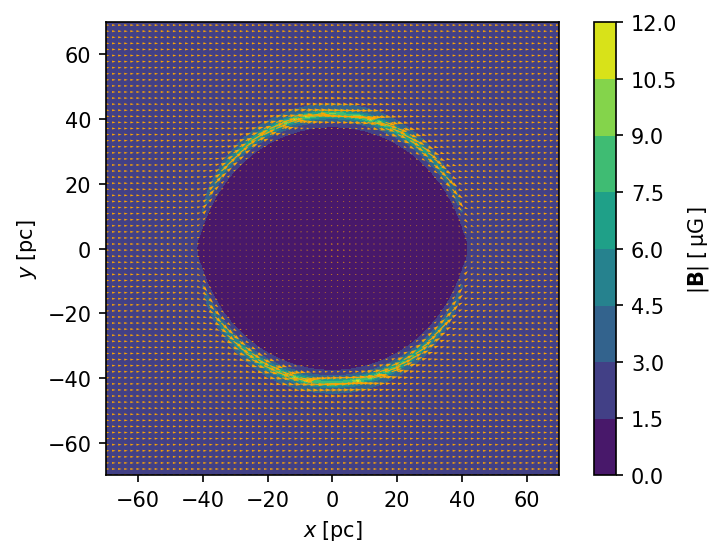

In [6]:
B_uniform = img_snrs.fields.SNRUniformMagneticField(grid,
                                                    parameters={'Bx':2*u.microgauss, 
                                                                'By':0*u.microgauss, 
                                                                'Bz':0*u.microgauss})
b_unif = B_uniform.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_unif_list = [b_unif[:,:,:,i] for i in range(3)]
shell.visualization.plot_vector_xy(grid, b_unif_list, skip=2);

As one can see, the shell properties are inherited from the electron density field.

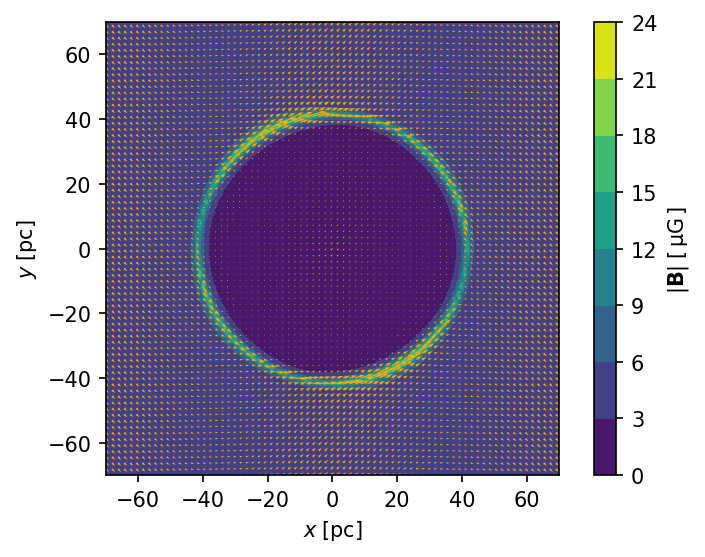

In [7]:
B_helical = img_snrs.fields.SNRHelicalMagneticField(grid,
                                                    parameters={'Bx':4*u.microgauss, 
                                                                'By':0*u.microgauss, 
                                                                'Bz':0*u.microgauss,
                                                                'period': 70*u.pc})
b_hel = B_helical.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_hel_list = [b_hel[...,i] for i in range(3)]
shell.visualization.plot_vector_xy(grid, b_hel_list, skip=2);

### Cosmic ray electrons

Formally, there should be an IMAGINE Field for the cosmic rays. There is, however, still no agreement on what is the adequate generic format for the cosmic ray field base class (due to the requirement of specifying the energy spectrum as well as the spatial distribution). So, we define a provisional base class within the `imagine_snrs` package.

We consider three possibilities of CR electrons, described below.


#### Constant CR

If we assume that the diffusion timescale is much smaller than the other timescales in the problem, the CRe are approximately constant within the box

In [8]:
CR_constant = img_snrs.fields.ConstantCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre': 0.01*u.cm**-3})
ncr_const = CR_constant.get_data()

In [9]:
ncr_const[0,0,0,0]

<Quantity 0.01 1 / cm3>


#### CR in energy equipartition with the magnetic field 

Another simple, but sound assumption

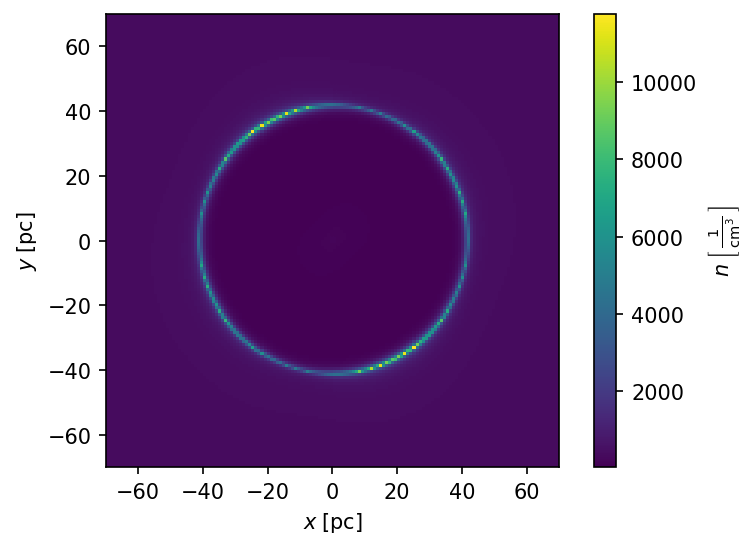

In [10]:
CR_equip = img_snrs.fields.EquipartitionCosmicRayElectrons(grid, 
                                                           parameters={'cr_energy': 1*u.GeV,
                                                                          'Em_Ecr': 1})
ncr_equip = CR_equip.get_data(dependencies={'magnetic_field': b_hel})

shell.visualization.plot_scalar_xy(grid, ncr_equip[...,0]);

#### CRe tracking thermal electorns 

Finally, for completeness, we consider the case where the accelaration process leads to CRe overdensities in the densest parts of the shell. A rough approximation to this is assuming that the CRe density is proportional to the thermal electron density.

In [11]:
CR_tracking = img_snrs.fields.TrackingCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre_nte': 1})
ncr_track = CR_tracking.get_data(dependencies={'thermal_electron_density': ne_data})

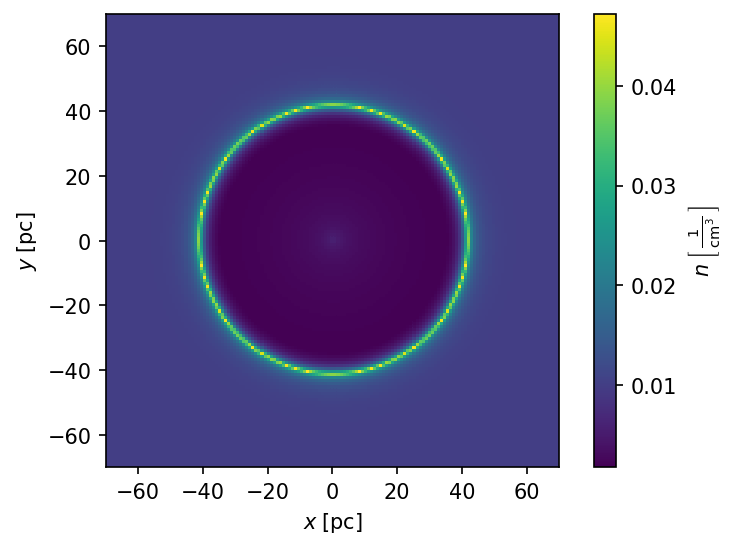

In [12]:
shell.visualization.plot_scalar_xy(grid, ncr_track[...,0]);

## Simulator class

Finally, it is necessary show IMAGINE how to convert the `Fields` into `Observables` using a [Simulator](https://imagine-code.readthedocs.io/en/latest/components.html#simulators) class (tutorial [here](https://imagine-code.readthedocs.io/en/latest/tutorial_simulator.html)).

I have implemented a simple simulator based on the contents of the original `observables` module within the `shell` package. It does not contain Darya's new features (e.g. beam size). 

In [13]:
from importlib import reload
reload(img_snrs)
reload(img_snrs.simulators)
reload(shell)
simulator = img_snrs.simulators.SimpleSynchrotron(measurements, 
                                                  distance=11.3*u.kpc, 
                                                  gamma=3.)

In [14]:
simulations = simulator([ne_field, CR_constant, B_helical])

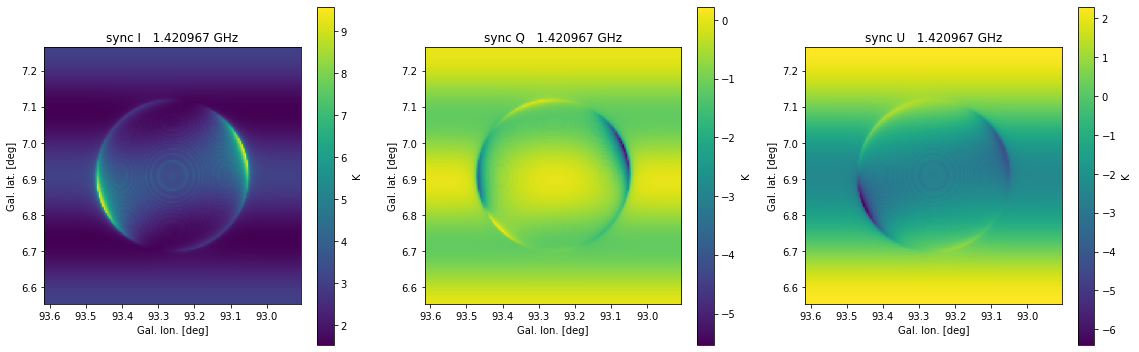

In [15]:
plt.figure(figsize=(16,5))
simulations.show()
plt.tight_layout()

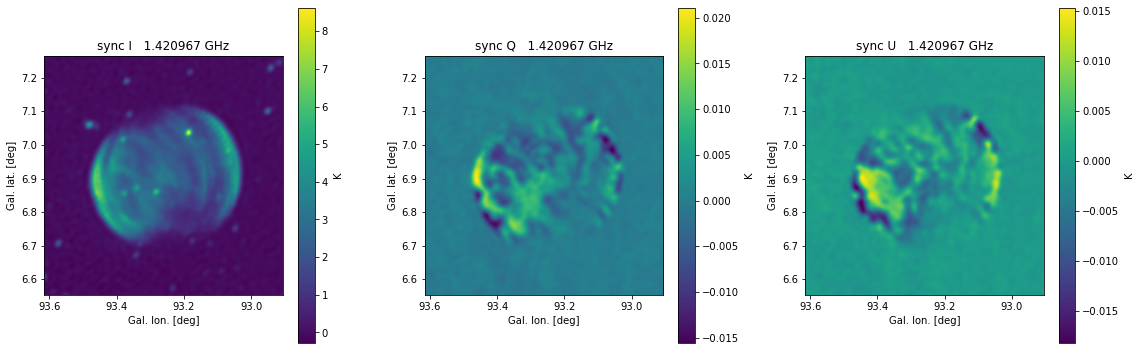

In [16]:
plt.figure(figsize=(16,5))
measurements.show()
plt.tight_layout()

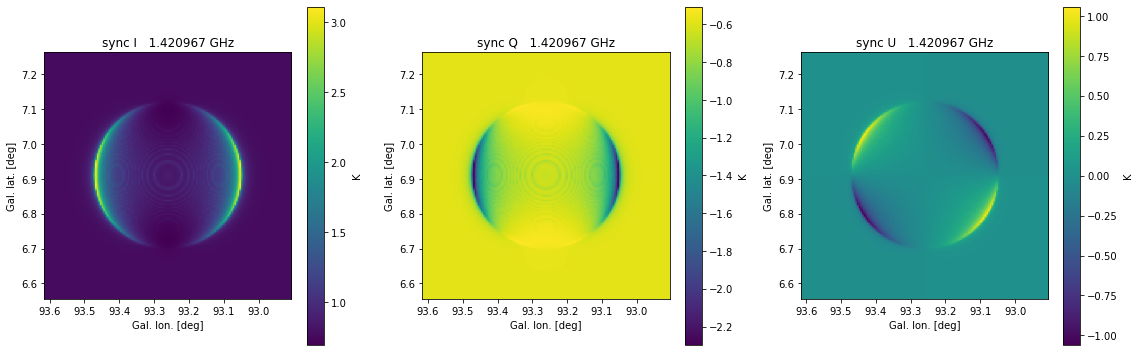

In [17]:
simulations = simulator([ne_field, CR_constant, B_uniform])
plt.figure(figsize=(16,5))
simulations.show()
plt.tight_layout()